In [10]:
# This is the main file that calls the functions to perform image stitching
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt

### Compute Homography H

In [11]:
def get_sift_points_cv(query_img, train_img):
    img1 = cv2.cvtColor(query_img, cv2.COLOR_RGB2GRAY)  # queryImage
    img2 = cv2.cvtColor(train_img, cv2.COLOR_RGB2GRAY)  # trainImage
    # img_color1 = cv2.imread(query_img, cv2.IMREAD_COLOR)  # queryImage
    # img_color2 = cv2.imread(train_img, cv2.IMREAD_COLOR)  # trainImage

    # Initiate SIFT detector
    sift = cv2.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp_img, des1 = sift.detectAndCompute(img1, None)
    kp_stitch, des2 = sift.detectAndCompute(img2, None)

    MIN_MATCH_COUNT = 10
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)

    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32([kp_img[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_stitch[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()
        h, w = img1.shape
        pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
        dst = cv2.perspectiveTransform(pts, M)
        img2 = cv2.polylines(img2, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
    else:
        print("Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT))
        matchesMask = None
        M = None

    draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                       singlePointColor=None,
                       matchesMask=matchesMask,  # draw only inliers
                       flags=2)

    # Display the image with RANSAC lines
    img3 = cv2.drawMatches(img1, kp_img, img2, kp_stitch, good, None, **draw_params)
    plt.imshow(img3, 'gray'), plt.show()
    
    plt.imshow(img3), plt.show()
    cv2.imwrite("assets/outputs/matches.jpg", img3)

    return M

In [12]:
# This file contains the function that computes the homography between two images
def compute_homography(keypoint1, keypoint2):
    # perform Normalized Direct Linear Transformation on the keypoints
    print("Shape of keypoints 1: ", keypoint1.shape)
    print("Shape of keypoints 2: ", keypoint2.shape)
    num_of_kps = keypoint1.shape[0]

    print("Shape of op:", np.transpose(np.column_stack((keypoint1, np.ones(num_of_kps)))).shape)
    keypoint1_homogeneous = np.column_stack((keypoint1, np.ones(num_of_kps)))
    keypoint2_homogeneous = np.column_stack((keypoint2, np.ones(num_of_kps)))

    # create the A matrix for Ah = 0
    A = []
    for i in range(num_of_kps):
        x1, y1, _ = keypoint1_homogeneous[i]
        x2, y2, _ = keypoint2_homogeneous[i]
        A.append([x1, y1, 1, 0, 0, 0, -x2 * x1, -x2 * y1, -x2])
        A.append([0, 0, 0, x1, y1, 1, -y2 * x1, -y2 * y1, -y2])

    A = np.array(A)  # shape = 2N x 9
    # B = np.dot(np.transpose(A), A)  # B = A^T*A

    _, _, V = np.linalg.svd(A)
    H = V[-1].reshape((3, 3))

    H = H / H[-1, -1]

    print('Final homography H:')
    print(H)

    return H

### Generate SIFT matches

In [13]:
# From OpenCV tutorial
def get_sift_points(query_img, train_img):
    img1 = cv2.imread(query_img, cv2.IMREAD_GRAYSCALE)  # queryImage
    img2 = cv2.imread(train_img, cv2.IMREAD_GRAYSCALE)  # trainImage
    img_color1 = cv2.imread(query_img, cv2.IMREAD_COLOR)  # queryImage
    img_color2 = cv2.imread(train_img, cv2.IMREAD_COLOR)  # trainImage
    
    # Initiate SIFT detector
    sift = cv2.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp_img, des1 = sift.detectAndCompute(img1, None)
    kp_stitch, des2 = sift.detectAndCompute(img2, None)

    ########### TEST 1 #############

    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    # Apply ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append([m])

    points_query = np.float32([kp_img[m.queryIdx].pt for m, n in matches if m.distance < 0.75 * n.distance])
    points_train = np.float32([kp_stitch[m.trainIdx].pt for m, n in matches if m.distance < 0.75 * n.distance])

    # cv.drawMatchesKnn expects list of lists as matches.
    img3 = cv2.drawMatchesKnn(img_color1, kp_img, img_color2, kp_stitch, good, None,
                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    ########### TEST 2 (WITH RANSAC) ###########

    # MIN_MATCH_COUNT = 10
    # FLANN_INDEX_KDTREE = 1
    # index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    # search_params = dict(checks = 50)
    # flann = cv2.FlannBasedMatcher(index_params, search_params)
    # matches = flann.knnMatch(des1,des2,k=2)
    # # store all the good matches as per Lowe's ratio test.
    # good = []
    # for m,n in matches:
    #     if m.distance < 0.7*n.distance:
    #         good.append(m)
    # 
    # if len(good)>MIN_MATCH_COUNT:
    #     src_pts = np.float32([ kp_img[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    #     dst_pts = np.float32([ kp_stitch[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    #     M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    #     matchesMask = mask.ravel().tolist()
    #     h,w = img1.shape
    #     pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    #     dst = cv2.perspectiveTransform(pts,M)
    #     img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    # else:
    #     print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    #     matchesMask = None
    # 
    # draw_params = dict(matchColor = (0,255,0), # draw matches in green color
    #                    singlePointColor = None,
    #                    matchesMask = matchesMask, # draw only inliers
    #                    flags = 2)
    # img3 = cv2.drawMatches(img1,kp_img,img2,kp_stitch,good,None,**draw_params)
    # plt.imshow(img3, 'gray'),plt.show()

    ####### TEST 3 (not quite working) #########

    # # find the keypoints and descriptors with SIFT
    # kp_img, des1 = sift.detectAndCompute(img1, None)
    # kp_stitch, des2 = sift.detectAndCompute(img2, None)
    # 
    # # initialize the Brute Force matcher (BFMatcher)
    # bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    # 
    # # match the descriptors
    # matches = bf.match(des1, des2)
    # 
    # # sort the matches based on distance
    # matches = sorted(matches, key = lambda x:x.distance)
    # img3 = cv2.drawMatches(img1, kp_img, img2, kp_stitch, matches[:300], None, flags=2)

    ############ TEST 4 IMAGE POINTS ################
    # # Initiate SIFT detector
    # sift = cv2.SIFT_create()
    # 
    # # find the keypoints with SIFT
    # kp1 = sift.detect(img_color1, None)
    # kp2 = sift.detect(img_color2, None)
    # 
    # # Draw keypoints on the images
    # img_keypoints1 = cv2.drawKeypoints(img_color1, kp1, img_color1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    # img_keypoints2 = cv2.drawKeypoints(img_color2, kp2, img_color2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    # 
    #     # find the descriptors with SIFT
    # kp1, des1 = sift.compute(img_color1, kp1)
    # kp2, des2 = sift.compute(img_color2, kp2)
    # 
    # good = good[:50]
    # 
    # # Use green color for match lines
    # img3 = cv2.drawMatchesKnn(img_keypoints1, kp1, img_keypoints2, kp2, good, None,
    #                           matchColor=(0, 255, 0),
    #                           flags=2)

    plt.imshow(img3), plt.show()
    print("Showing matches")
    cv2.imwrite("assets/outputs/matches.jpg", img3)

    # Convert kp object into numpy array
    kp_img_list = [kp.pt for kp in kp_img]
    kp_stitch_list = [kp.pt for kp in kp_stitch]

    kp_img_np = np.array(kp_img_list)
    kp_stitch_np = np.array(kp_stitch_list)

    return points_query, points_train

Test for the get sift points function

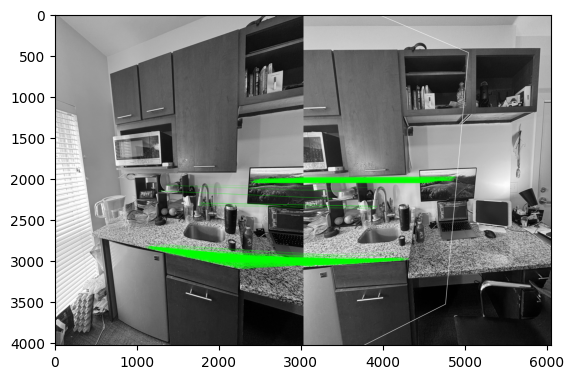

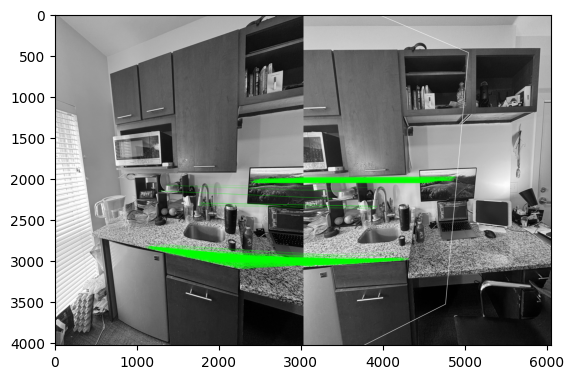

In [14]:
img1_path = "assets/inputs/room_center.png"
img2_path = "assets/inputs/room_left.png"
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)

# kp_pts, kp_im_pts = get_sift_points(img2_path, img1_path)
M = get_sift_points_cv(img2, img1)

# print(kp_pts.shape)

### Function for running RANSAC

In [15]:
# Functon runRANSAC: x_dest are the destination points, x_src are the points from source, ransac_itr is the number of iterations, threshold.
def run_ransac(x_src, x_dest, ransac_itr, threshold):
    # H, mask = cv2.findHomography(np.float32(kp_img), np.float32(kp_stitch), cv2.RANSAC, threshold)
    num_pts = len(x_src)
    pts_id = np.arange(num_pts)
    max_M = 0
    best_H = None
    inliers_id = np.array([])
    print("Keypoint shapes", x_src.shape, x_dest.shape)

    for iter in range(ransac_itr):
        inds = np.random.choice(num_pts, 4, replace=False)
        pts_src = x_src[inds, :]
        pts_dst = x_dest[inds, :]

        # Compute the homography matrix
        ######### USING CV2 ############
        H, _ = cv2.findHomography(pts_src, pts_dst, method=cv2.RANSAC)

        ######## HW Homography Function ###########
        # H = compute_homography(pts_src, pts_dst)
        # Project source points to destination using homography
        ones = np.ones((num_pts, 1))

        # Convert to homogenous coordinates
        x_src_homog = np.hstack((x_src, ones))
        projected_pts = H @ x_src_homog.T
        projected_pts /= projected_pts[2, :]  # Convert from homogenous to Cartesian coords

        # Calculate distances
        temp = projected_pts[:2, :].T
        print("Shape of temp:", temp.shape)
        print("Shape of x_dest:", x_dest.shape)
        dist = np.sqrt(np.sum((temp - x_dest) ** 2, axis=1))

        # Determine inliers
        i = dist < threshold
        num_inliers = np.sum(i)

        # Update best model if current model is better
        if num_inliers > max_M:
            max_M = num_inliers
            best_H = H
            inliers_id = np.where(i)[0]  # Store the indices of the inliers

    if max_M > 8:  # at least 4 point correspondences
        x_src_inliers = x_src[inliers_id, :]
        x_dest_inliers = x_dest[inliers_id, :]
        best_H = compute_homography(x_src_inliers, x_dest_inliers)

    return inliers_id, best_H


def run_ransac_cv(x_src, x_dest, threshold):
    # Convert points to the required data type
    pts_src = x_src.astype('float32')
    pts_dst = x_dest.astype('float32')

    # Compute the homography matrix using RANSAC
    H, mask = cv2.findHomography(pts_src, pts_dst, cv2.RANSAC, threshold)

    # Find the inliers
    inliers_cv_id = np.where(mask.flatten() == 1)[0]

    return inliers_cv_id, H

Code to test the ransac script

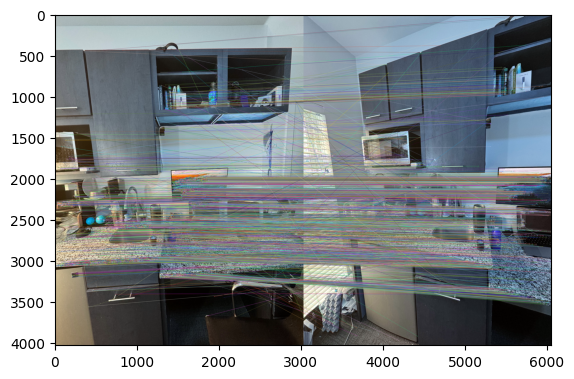

Showing matches


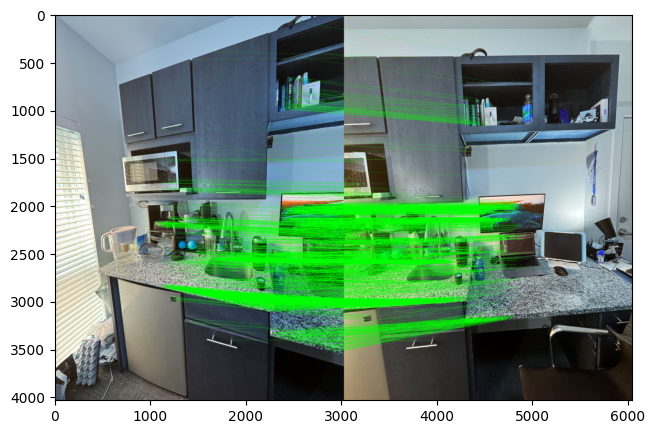

In [16]:
img1_path = "assets/inputs/room_center.png"
img2_path = "assets/inputs/room_left.png"
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)
kp_stitched, kp_img = get_sift_points(img1_path, img2_path)

# inliers_id, best_H = run_ransac(kp_img, kp_stitched, 500, 5)
inliers_id, best_H = run_ransac_cv(kp_img, kp_stitched, 500)

def draw_matches(img1, kp_img, img2, kp_stitched, inliers):
    """
    Draws lines between matching keypoints of two images.
    Only inliers are drawn.
    img1, img2: source and destination images
    kp1, kp2: keypoints from both images
    inliers: array of indices of inliers to be drawn
    """
    # Create a blank image that fits both the input images
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    nWidth = w1 + w2
    nHeight = max(h1, h2)
    hdif = (h1 - h2) // 2
    new_img = np.zeros((nHeight, nWidth, 3), dtype=np.uint8)
    new_img[hdif:hdif + h2, :w2] = img2
    new_img[:h1, w2:w1 + w2] = img1

    # Draw lines for inliers
    for i in inliers:
        pt1 = (int(kp_stitched[i][0] + w2), int(kp_stitched[i][1]))
        pt2 = (int(kp_img[i][0]), int(kp_img[i][1]) + hdif)

        # color = tuple(np.random.randint(0, 255, 3).tolist())
        color = (0, 255, 0)
        cv2.line(new_img, pt1, pt2, color, 1)

    plt.figure(figsize=(10, 5))
    plt.imshow(new_img)
    cv2.imwrite("assets/outputs/ransac.jpg", new_img)
    plt.show()

draw_matches(img1, kp_img, img2, kp_stitched, inliers_id)

#### Code to backward warp the image, resampling the image based on H matrix. Maps the destinage image region to the source image and copies the pixel value. 

In [17]:
# Function to applyHomography
def applyHomography(H, pts):
    # get points
    t_pts = np.dot(H, np.array([pts[0], pts[1], 1]))
    return t_pts[0] / t_pts[2], t_pts[1] / t_pts[2]


def backward_warp(src_img, resultToSrc_H, dest_width, dest_height):
    src_height, src_width = src_img.shape[:2]

    # Initialize output image and mask, using the src_img channels
    result_img = np.zeros((dest_height, dest_width, src_img.shape[2]), dtype=np.uint8)
    mask = np.zeros((dest_height, dest_width), dtype=np.uint8)  # set mask to 0's

    # Go through all points in the output image
    for i in range(dest_height):
        for j in range(dest_width):
            # Map point to source image
            x, y = applyHomography(resultToSrc_H, (i, j))
            
            # Checking if point lies in source image
            if x >= 0 and y >= 0 and x < src_width and y < src_height:
                result_img[i, j, :] = cv2.getRectSubPix(src_img, (1, 1), (x, y))
                mask[i, j] = 1 # update mask at proper position in new image

    cv2.imshow('Result Image', result_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.imwrite('assets/outputs/bward.jpg', result_img)
    return mask, result_img

### Open CV Warp method

In [18]:
def warp_cv(src_img, stitched_img, resultToSrc_H, dest_width, dest_height):
    # Define size of the output image
    size = (dest_width, dest_height)

    # Determine the inverse homography matrix
    inv_H = np.linalg.inv(resultToSrc_H)

    # Perform the warp using inverse homography
    result_img = cv2.warpPerspective(src_img, inv_H, size)

    # Blending the warped image with the second image using alpha blending
    alpha = 0.5  # blending factor
    blended_image = cv2.addWeighted(result_img, alpha, stitched_img, 1 - alpha, 0)
    
    # Create a mask based on where we have non-zero pixels in the result
    mask = np.sum(blended_image, axis=2) > 0
    cv2.imwrite('assets/outputs/bward.jpg', blended_image)
    return mask, blended_image

#### Code to blend the image pair

In [19]:
def blend_img(dest_img, mask, stitched_img, stitch_mask, blend_mode):
    assert dest_img.dtype == stitched_img.dtype, "Images types do not match"
    assert dest_img.dtype in [np.uint8, np.float32, np.float64], "Images types are not known"
    eps = 1e-10  # small constant

    # Get dimensions
    H, W, C = dest_img.shape

    # Initialize output image as zeros
    out_img = np.zeros((H, W, C), dtype=np.float64)
    input_type = dest_img.dtype

    # Convert inputs to float64 to avoid overflow/underflow issues
    dest_img = dest_img.astype(np.float64)
    stitched_img = stitched_img.astype(np.float64)

    # Create binary masks
    binary_mask_s = mask > 0
    binary_mask_d = stitch_mask > 0

    for c in range(C):
        channel_out = np.zeros((H, W), dtype=np.float64)
        S = dest_img[:, :, c]
        D = stitched_img[:, :, c]
        if blend_mode == 'overlay':
            # s first, then d overwrites s wherever there is overlap.
            channel_out[binary_mask_s] = S[binary_mask_s]
            channel_out[binary_mask_d] = D[binary_mask_d]
        elif blend_mode == 'blend':
            print(f"Mask_s shape: {mask.shape}")
            print(f"Mask_d shape: {stitch_mask.shape}")
            print(f"S shape: {dest_img.shape}")
            print(f"D shape: {stitched_img.shape}")
            
            # Use distance_transform_edt for Euclidean distance transformation
            weighted_mask_s = distance_transform_edt(np.logical_not(binary_mask_s))
            weighted_mask_d = distance_transform_edt(np.logical_not(binary_mask_d))
            mask_intersection = np.logical_or(binary_mask_s, binary_mask_d)
            channel_out[mask_intersection] = (S[mask_intersection] * weighted_mask_s[mask_intersection] + D[mask_intersection] * weighted_mask_d[mask_intersection]) / (weighted_mask_s[mask_intersection] + weighted_mask_d[mask_intersection] + eps)
        out_img[:, :, c] = channel_out

    # Convert back to the same type as input
    if input_type == np.uint8:
        # clip to 0-255 range after rounding
        out_img = np.round(out_img).clip(0, 255).astype(np.uint8)
    elif input_type == np.float32:
        out_img = out_img.astype(np.float32)
    
    return out_img

In [20]:
def crop_image(image, ref_start_y, ref_img_height):
    cropped_image = image[ref_start_y: ref_start_y + ref_img_height, :]
    return cropped_image

def remove_black_edges(image):
    # Find the first column that is not entirely black (all values are 0)
    non_black_columns = np.where(image.min(axis=(0, 2)) > 0)[0]
    leftmost_non_black_column = non_black_columns[0]
    
    # Crop the image to remove the black pixels on the left
    cropped_image = image[:, leftmost_non_black_column:]
    return cropped_image


### Image stitching main function

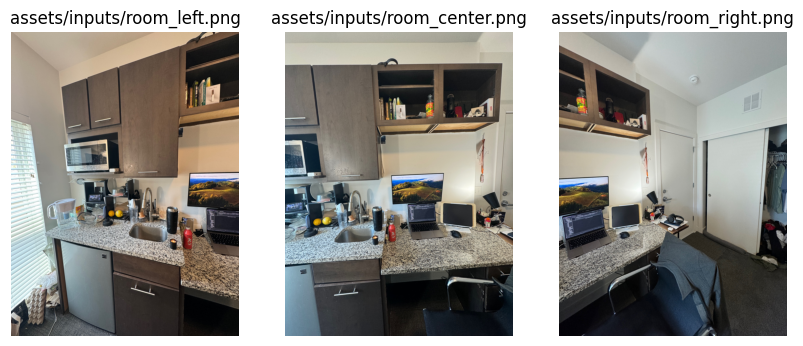

y_stitched:  12096
x_stitched:  9072


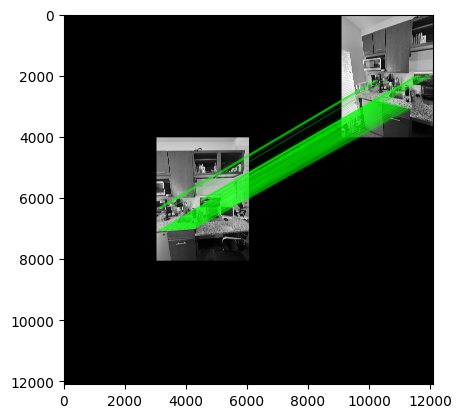

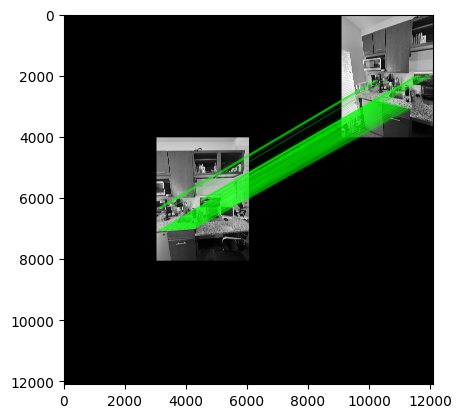

H Shape (3, 3)
mask shape (12096, 9072)
dest_img shape (12096, 9072, 3)


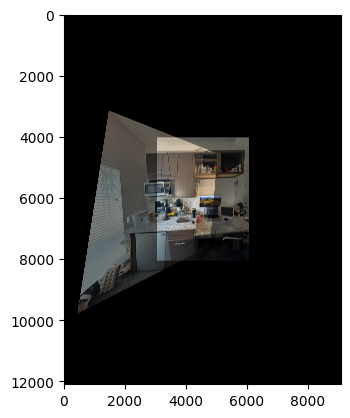

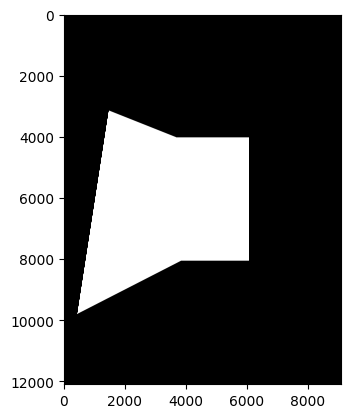

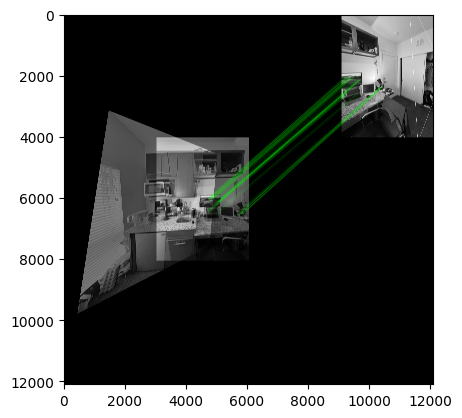

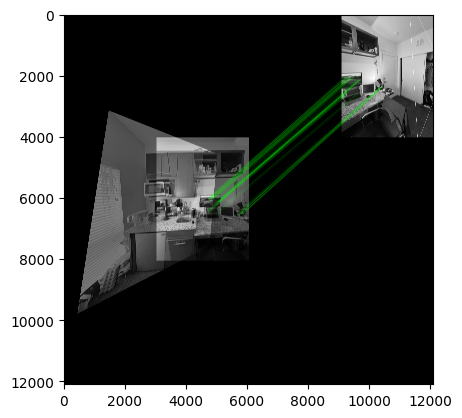

H Shape (3, 3)
mask shape (12096, 9072)
dest_img shape (12096, 9072, 3)


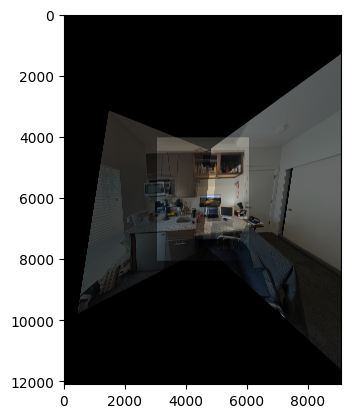

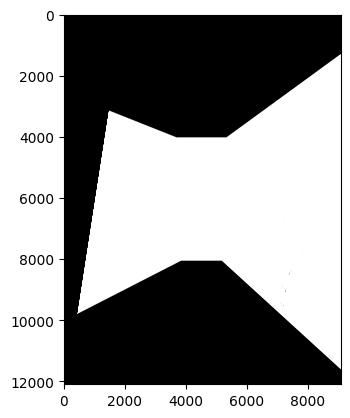

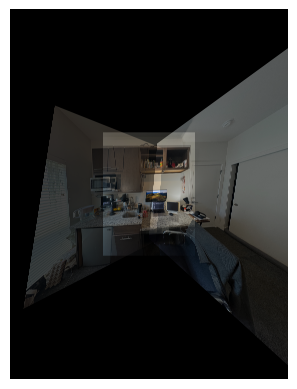

In [21]:
def image_stitcher(*image_paths):
    images = [cv2.imread(path, cv2.IMREAD_COLOR) for path in image_paths]

    # Convert BGR image to RGB image
    images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images]

    # Display images
    fig, axes = plt.subplots(1, len(images), figsize=(10, 5))
    for i, (img, path) in enumerate(zip(images, image_paths)):
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(path)
    plt.show()

    # Get total number of vertical pixels
    y_stitched = sum(img.shape[0] for img in images)  # Sum of heights
    x_stitched = sum(img.shape[1] for img in images)  # Sum of widths
    print("y_stitched: ", y_stitched)
    print("x_stitched: ", x_stitched)
    channel_stitch = images[0].shape[2]  # Set the channel (color)

    # Create an array for the stitched image (initializing to 0)
    stitched_img = np.zeros((y_stitched, x_stitched, channel_stitch), dtype=images[0].dtype)
    num_images = len(images) - 1  # number of images to be stitched
    middle_img_idx = num_images // 2  # index of the center image

    # Setting the reference image (image to stitch around)
    ref_img = images[middle_img_idx]

    # Size of the ref image
    ref_img_height = ref_img.shape[0]
    ref_img_width = ref_img.shape[1]

    # Calculate the starting position  ensuring they fit within the dimensions of the stitched image (floor division is done using, //)
    ref_start_x = max(0, min((x_stitched - ref_img_width) // 2, x_stitched - ref_img_width))
    ref_start_y = max(0, min((y_stitched - ref_img_height) // 2, y_stitched - ref_img_height))

    # Initialize binary mask for tracking filled areas (0 is not filled, otherwise filled) and gets updated each time new area is filled
    stitch_mask = np.zeros((y_stitched, x_stitched))
    stitch_mask[ref_start_y:ref_start_y + ref_img_height, ref_start_x:ref_start_x + ref_img_width] = 1

    # Create the starting image stitch (starts with center image)
    stitched_img[ref_start_y:ref_start_y + ref_img_height, ref_start_x:ref_start_x + ref_img_width, :] = ref_img

    plt.imsave("assets/outputs/stitched_img.png", stitched_img)
    plt.imsave("assets/outputs/stitched_mask.png", stitch_mask)

    for idx, img in enumerate(images):
        # Skip past the middle image
        if idx == middle_img_idx:
            continue

        # Generate SIFT matches from indexed image and the current stitched image (Generates kp for stitched image and current image)
        """--------- Without OpenCV ------------ """
        # kp_stitch, kp_img = get_sift_points(stitched_img, img)
        #inliers_id, best_H = run_ransac(kp_img, kp_stitch, 300, 1)

        """ ----- With OpenCV (get sift points needs to return homography matrix) ---- """
        best_H = get_sift_points_cv(stitched_img, img)
        print("H Shape", best_H.shape)
        if (best_H is None):
            print("Can not stitch images")
            
        # Get the new mask and new destination image
        # mask, dest_img = backward_warp(img, best_H, y_stitched, x_stitched)
        mask, dest_img = warp_cv(img, stitched_img, best_H, x_stitched, y_stitched)
        print("mask shape", mask.shape)
        print("dest_img shape", dest_img.shape)

        # stitched_img = blend_img(dest_img, mask, stitched_img, stitch_mask, 'blend')
        # Or the mask
        plt.imshow(dest_img)
        plt.show()
        stitched_img = dest_img        
        stitch_mask = np.logical_or(stitch_mask, mask)
        plt.imshow(stitch_mask, cmap="gray")
        plt.show()

    # stitched_img = crop_image(stitched_img, ref_start_y, ref_img_height)
    # stitched_img = remove_black_edges(stitched_img)
    # stitched_img = remove_black_cropping(stitched_img)
    return stitched_img


# Testing images
img1_path = "assets/inputs/room_left.png"
img2_path = "assets/inputs/room_center.png"
img3_path = "assets/inputs/room_right.png"

result_img = image_stitcher(img1_path, img2_path, img3_path)
plt.imshow(result_img)
cv2.imwrite('assets/outputs/final_stitch.jpg', result_img)
plt.axis('off')
plt.show()